In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [76]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

 Данные в компании, которая занимается арендой велосипедов за два года: с 4 января 2015 по 3 января 2017

In [77]:
data = pd.read_csv('C:/Users/1/JupyterProjects/Karpov_courses_lessons_and_projects/module_statistics/all_data/london.csv', parse_dates=['timestamp'])

In [78]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


Для начала попробуем посмотреть на число поездок по датам и времени.

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

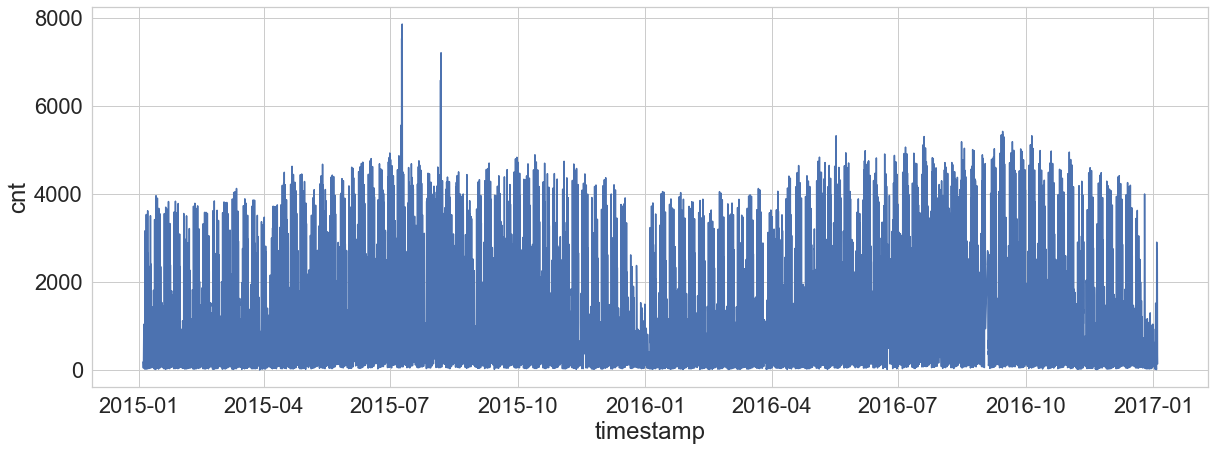

In [80]:
sns.lineplot(data=data, x='timestamp', y='cnt')

Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

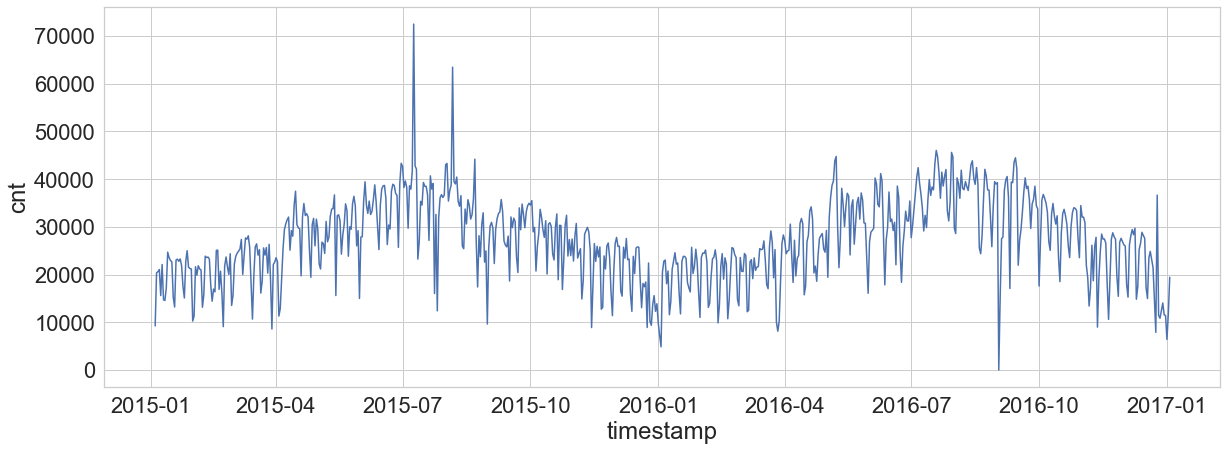

In [81]:
# используем resample для визуализации данных по дням
data.sort_values(by='timestamp', inplace=True) # сортировка на всякий случай
sns.lineplot(data=data.set_index('timestamp').resample(rule='D').cnt.sum())

Заметим на графике сезонность: летом количество прокатов больше чем зимой, что в целом разумно, а также можно увидеть резкие скачки и довольно сильно отклоняющиеся значения.

Попробуем построить доверительный интервал вокруг данных - всё, что выпадает за его пределы, будет считаться аномалией, и на отдельные из них мы потом и посмотрим.
Так как мы сейчас работаем с временным рядом - последовательностью значений, меняющейся во времени, мы не можем просто так посчитать доверительный интервал для всего: так мы можем упустить важные характеристики данных! Например, сезонные колебания. 

Чтобы учесть этот момент, мы построим доверительный интервал, используя скользящее среднее. Для этого разделим дальнейшие действия на несколько этапов:

сначала посчитаем скользящее среднее, чтобы сгладить ряд

далее – разницу между наблюдаемыми и сглаженными значениями

определим верхние и нижние границы 99% доверительного интервала 

найдем причины аномалий!

In [82]:
resample_data = data.set_index('timestamp').resample(rule='D').agg({'cnt': 'sum'})

In [83]:
resample_data.head()

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601


In [84]:
resample_data_rolling = resample_data.rolling(window=3).mean()

<AxesSubplot:xlabel='timestamp'>

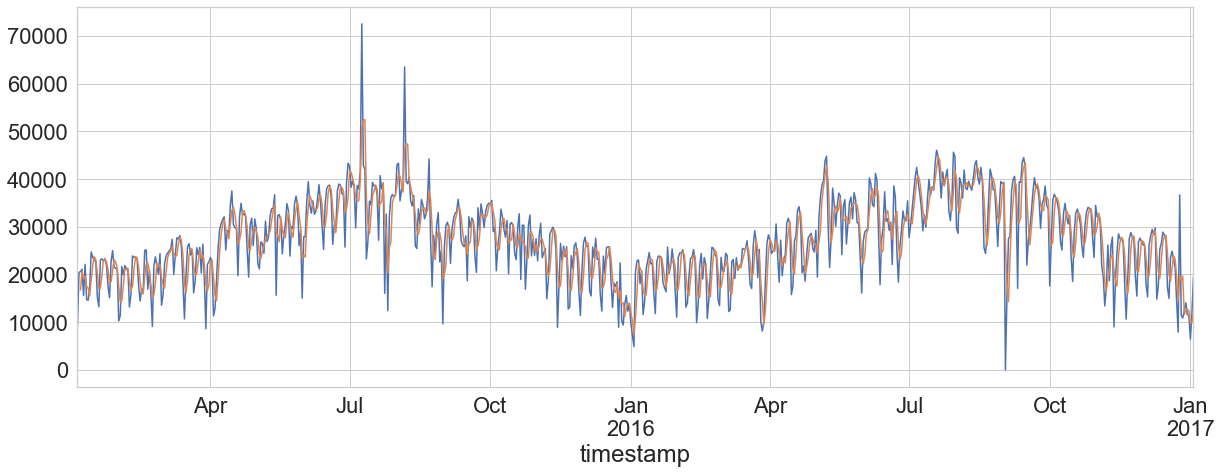

In [85]:
resample_data.cnt.plot()
resample_data_rolling.cnt.plot()

In [86]:
difference = resample_data - resample_data_rolling

In [87]:
std = np.std(difference)

C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

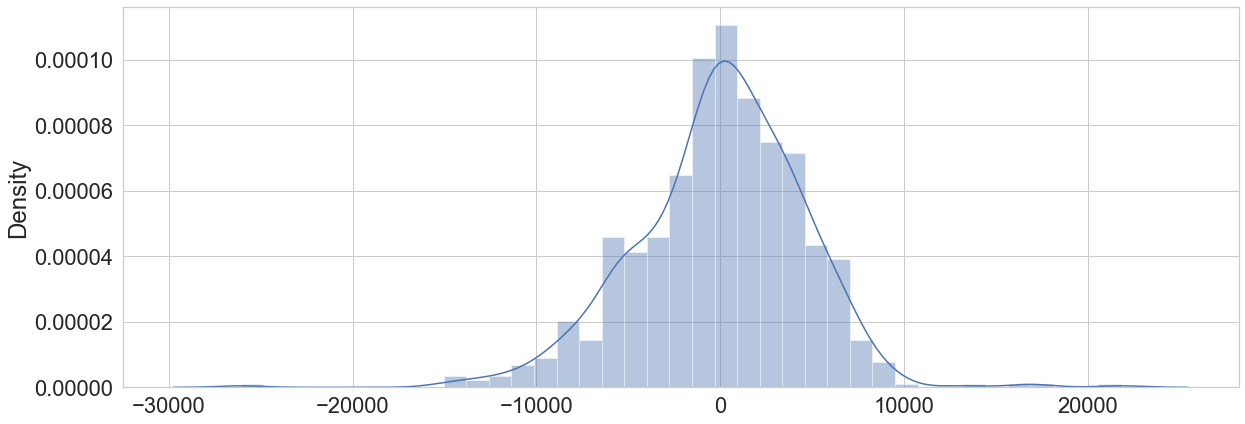

In [88]:
sns.distplot(difference)

In [89]:
# верхняя граница 99% доверительного интервала
upper_bound = resample_data_rolling + 2.576 * std

In [90]:
# нижняя граница 99% доверительного интервала
lower_bound = resample_data_rolling - 2.576 * std

In [91]:
resample_data.reset_index(inplace=True)

In [92]:
resample_data['upper_bound'] = upper_bound.reset_index().cnt
resample_data['lower_bound'] = lower_bound.reset_index().cnt

In [93]:
resample_data

,timestamp,cnt,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,28482.585854,4996.747479
3,2015-01-07,21064,32425.919188,8940.080812
4,2015-01-08,15601,30835.585854,7349.747479
...,...,...,...,...
726,2016-12-30,11566,24424.919188,939.080812
727,2016-12-31,11424,24090.252521,604.414146
728,2017-01-01,6421,21546.585854,-1939.252521
729,2017-01-02,11823,21632.252521,-1853.585854


Изучим наши аномалии

In [94]:
resample_data.query('cnt > upper_bound')

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.919188,38962.080812
214,2015-08-06,63468,58370.252521,34884.414146
609,2016-09-04,27512,26001.919188,2516.080812
721,2016-12-25,36653,31393.585854,7907.747479


Наибольшее число аренд было 2015-07-09, давайте выясним причину такого сильного отклонения

In [95]:
# посмотрим на данные за все 24 часа
data[data.timestamp.dt.strftime('%Y-%m-%d') == '2015-07-09']

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4453,2015-07-09 00:00:00,400,16.0,16.0,55.0,14.0,1.0,0.0,0.0,1.0
4454,2015-07-09 01:00:00,212,15.5,15.5,59.0,14.0,1.0,0.0,0.0,1.0
4455,2015-07-09 02:00:00,111,14.0,14.0,67.0,15.0,1.0,0.0,0.0,1.0
4456,2015-07-09 03:00:00,81,14.0,14.0,63.0,18.5,1.0,0.0,0.0,1.0
4457,2015-07-09 04:00:00,76,14.0,14.0,63.0,18.0,1.0,0.0,0.0,1.0
4458,2015-07-09 05:00:00,269,13.0,13.0,67.0,17.0,1.0,0.0,0.0,1.0
4459,2015-07-09 06:00:00,1724,13.0,13.0,67.0,16.0,1.0,0.0,0.0,1.0
4460,2015-07-09 07:00:00,5309,13.5,13.5,65.0,17.0,1.0,0.0,0.0,1.0
4461,2015-07-09 08:00:00,7531,14.5,14.5,61.0,19.0,2.0,0.0,0.0,1.0
4462,2015-07-09 09:00:00,4832,15.0,15.0,59.0,16.0,2.0,0.0,0.0,1.0


In [96]:
# проверим на наличие дубликатов
data[data.duplicated()]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season


Немного погуглим и выясним, что в этот день в лондоне случился транспортный коллапс

In [97]:
resample_data.query('cnt < lower_bound')

,timestamp,cnt,upper_bound,lower_bound
130,2015-05-14,15609,40452.252521,16966.414146
189,2015-07-12,23240,47779.585854,24293.747479
201,2015-07-24,16034,42756.585854,19270.747479
232,2015-08-24,17400,41272.252521,17786.414146
314,2015-11-14,8898,32780.252521,9294.414146
607,2016-09-02,0,37829.252521,14343.414146
615,2016-09-10,17080,43004.919188,19519.080812
621,2016-09-16,21967,47936.252521,24450.414146
678,2016-11-12,8990,32620.919188,9135.080812


In [98]:
# посмотрим на данные за все 24 часа
data[data.timestamp.dt.strftime('%Y-%m-%d') == '2016-09-02']

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season


Судя по всему ошибка при сборе данных: данные могли не записаться